In [142]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Masking
)
from tensorflow.keras.optimizers import Adam


In [93]:
sns.set(style="whitegrid", context="talk")


In [94]:
DATA_PATH = "data/"

column_names = (
    ["engine_id", "cycle",
     "op_setting_1", "op_setting_2", "op_setting_3"]
    + [f"sensor_{i}" for i in range(1, 22)]
)

train_df = pd.read_csv(
    DATA_PATH + "train_FD001.txt",
    sep=r"\s+",
    header=None,
    names=column_names,
    engine="python"
)

test_df = pd.read_csv(
    DATA_PATH + "test_FD001.txt",
    sep=r"\s+",
    header=None,
    names=column_names,
    engine="python"
)

rul_df = pd.read_csv(
    DATA_PATH + "RUL_FD001.txt",
    header=None,
    names=["RUL"]
)

# Drop accidental NaNs from parsing
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("Train engines:", train_df["engine_id"].nunique())
print("Test engines:", test_df["engine_id"].nunique())
print("RUL entries:", len(rul_df))


Train engines: 100
Test engines: 100
RUL entries: 100


In [95]:
train_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [96]:
train_df.describe().T


,count,mean,std,min,25%,50%,75%,max
engine_id,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


In [97]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

In [98]:
train_df.columns

Index(['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'],
      dtype='object')

In [99]:
train_df[['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']].nunique()


engine_id        100
cycle            362
op_setting_1     158
op_setting_2      13
op_setting_3       1
sensor_1           1
sensor_2         310
sensor_3        3012
sensor_4        4051
sensor_5           1
sensor_6           2
sensor_7         513
sensor_8          53
sensor_9        6403
sensor_10          1
sensor_11        159
sensor_12        427
sensor_13         56
sensor_14       6078
sensor_15       1918
sensor_16          1
sensor_17         13
sensor_18          1
sensor_19          1
sensor_20        120
sensor_21       4745
dtype: int64

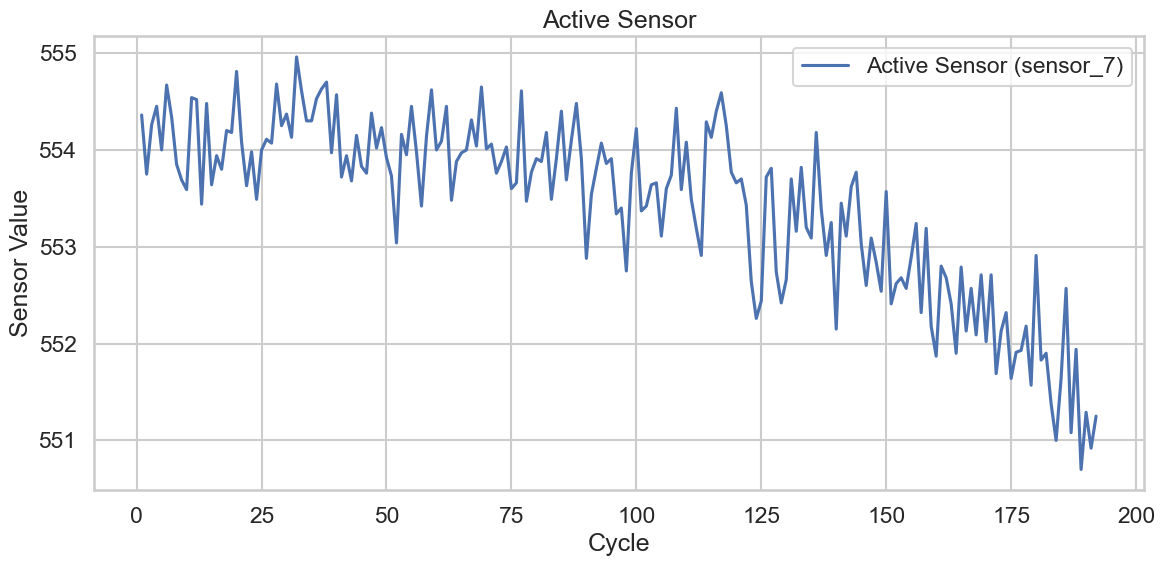

In [100]:

engine_id = 1
engine_data = train_df[train_df["engine_id"] == engine_id]
active_sensor = "sensor_7"
dead_sensor = "sensor_1"

plt.figure(figsize=(12, 6))

sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data[active_sensor],
    label=f"Active Sensor ({active_sensor})"
)

# sns.lineplot(
#     x=engine_data["cycle"],
#     y=engine_data[dead_sensor],
#     label=f"Dead Sensor ({dead_sensor})",
#     linestyle="--"
# )

plt.xlabel("Cycle")
plt.ylabel("Sensor Value")
plt.title("Active Sensor")
plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Dead sensor(Constant value)')

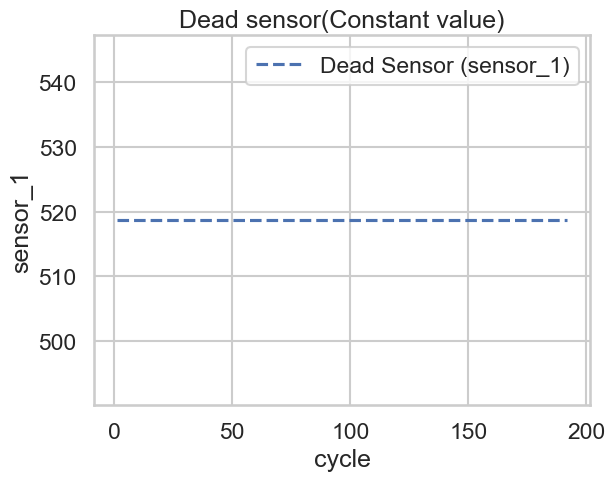

In [101]:
sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data[dead_sensor],
    label=f"Dead Sensor ({dead_sensor})",
    linestyle="--"
)
plt.title("Dead sensor(Constant value)")

In [103]:
max_cycles = train_df.groupby("engine_id")["cycle"].max()

train_df["RUL_raw"] = (
    max_cycles[train_df["engine_id"]].values
    - train_df["cycle"]
)

# train_df[["engine_id", "cycle", "RUL_raw"]].head()
DEGRADATION_START = 133.7

display_df = train_df[["engine_id", "cycle", "RUL_raw"]].copy()

display_df["phase"] = display_df["RUL_raw"].apply(
    lambda x: "Healthy (Full Life)" if x > DEGRADATION_START else "Degrading Phase"
)

display_df.head(10)




,engine_id,cycle,RUL_raw,phase
0,1,1,191,Healthy (Full Life)
1,1,2,190,Healthy (Full Life)
2,1,3,189,Healthy (Full Life)
3,1,4,188,Healthy (Full Life)
4,1,5,187,Healthy (Full Life)
5,1,6,186,Healthy (Full Life)
6,1,7,185,Healthy (Full Life)
7,1,8,184,Healthy (Full Life)
8,1,9,183,Healthy (Full Life)
9,1,10,182,Healthy (Full Life)


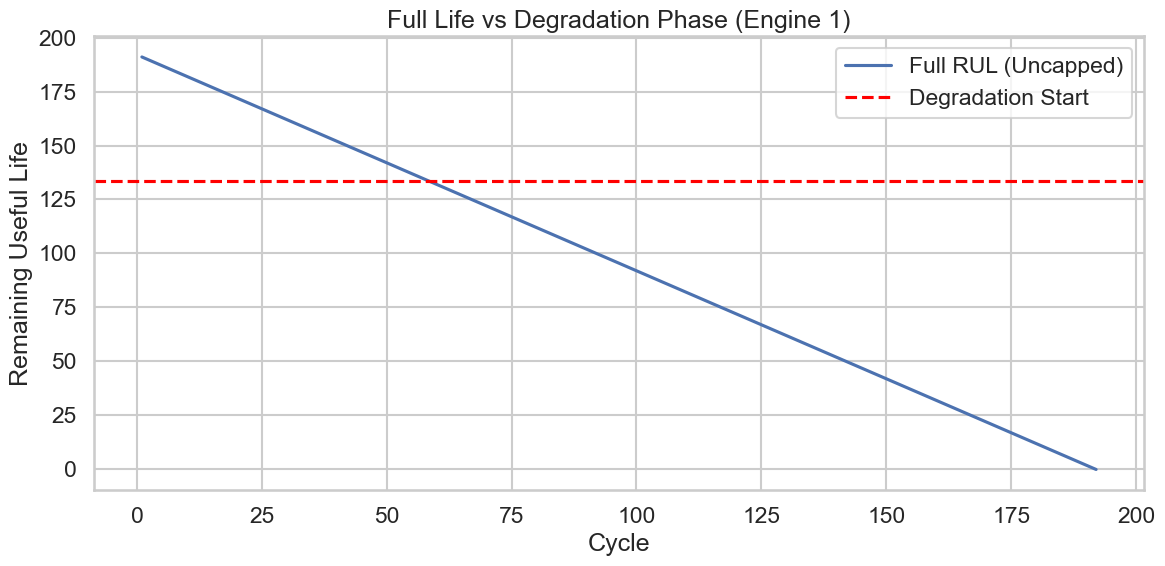

In [104]:
#Show the degradation of engine life over time
engine_id = 1
engine_data = train_df[train_df["engine_id"] == engine_id]

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data["RUL_raw"],
    label="Full RUL (Uncapped)"
)

plt.axhline(
    y=DEGRADATION_START,
    color="red",
    linestyle="--",
    label="Degradation Start"
)

plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life")
plt.title(f"Full Life vs Degradation Phase (Engine {engine_id})")
plt.legend()
plt.tight_layout()
plt.show()


In [106]:
#capping the RUL to a fixed num
max_cycles = train_df.groupby("engine_id")["cycle"].max()

train_df["RUL"] = train_df.apply(
    lambda row: max_cycles[row["engine_id"]] - row["cycle"],
    axis=1
)
MAX_RUL = 125
train_df["RUL"] = train_df["RUL"].clip(upper=MAX_RUL)
display_df = train_df[["engine_id", "cycle", "RUL"]].copy()

# print(display_df.head())


In [116]:
drop_sensors = [
    "sensor_1", "sensor_5", "sensor_6","op_setting_3",
    "sensor_10", "sensor_16", "sensor_18", "sensor_19"
]

train_df.drop(columns=drop_sensors, inplace=True)
test_df.drop(columns=drop_sensors, inplace=True)

In [117]:
train_df.columns

Index(['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'sensor_2',
       'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17',
       'sensor_20', 'sensor_21', 'RUL_raw', 'RUL'],
      dtype='object')

In [118]:
train_df["RUL"].describe()

count    20631.000000
mean        86.829286
std         41.673699
min          0.000000
25%         51.000000
50%        103.000000
75%        125.000000
max        125.000000
Name: RUL, dtype: float64

In [119]:
# Base model 
# Lifespan Statistics
engine_lifespan = train_df.groupby('engine_id')['cycle'].max()

print("Mean Lifespan:", engine_lifespan.mean())
print("Min Lifespan:", engine_lifespan.min())
print("Max Lifespan:", engine_lifespan.max())

Mean Lifespan: 206.31
Min Lifespan: 128
Max Lifespan: 362


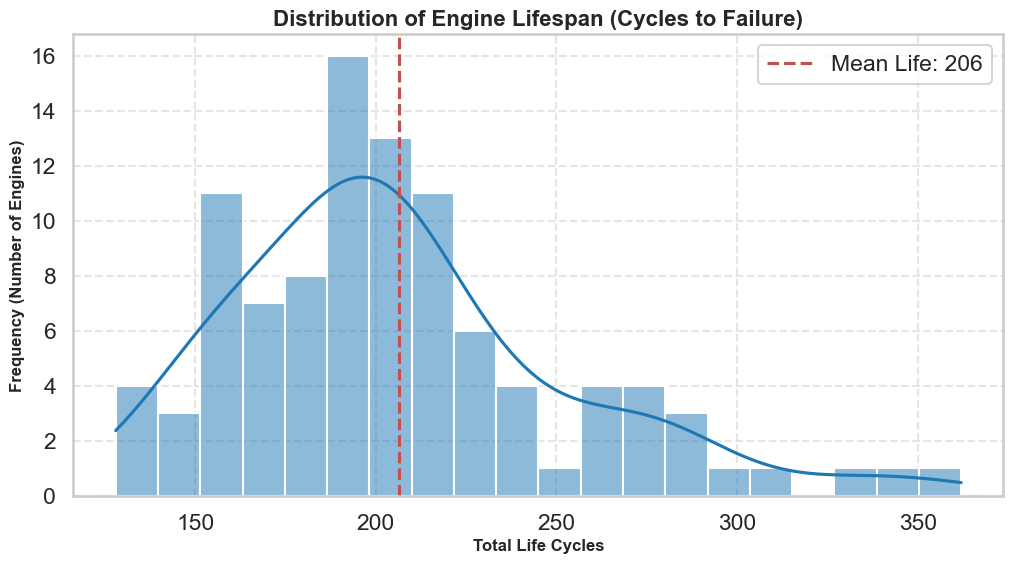

In [120]:
# Lifespan Distribution

# Histogram (Distribution)
plt.figure(figsize=(12, 6))
sns.histplot(engine_lifespan, kde=True, color='#1f77b4', bins=20)
plt.title('Distribution of Engine Lifespan (Cycles to Failure)', fontweight='bold', size=16)
plt.xlabel('Total Life Cycles', fontweight='bold', size=12)
plt.ylabel('Frequency (Number of Engines)', fontweight='bold', size=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axvline(engine_lifespan.mean(), color='r', linestyle='--', label=f'Mean Life: {int(engine_lifespan.mean())}')
plt.legend()
plt.show()

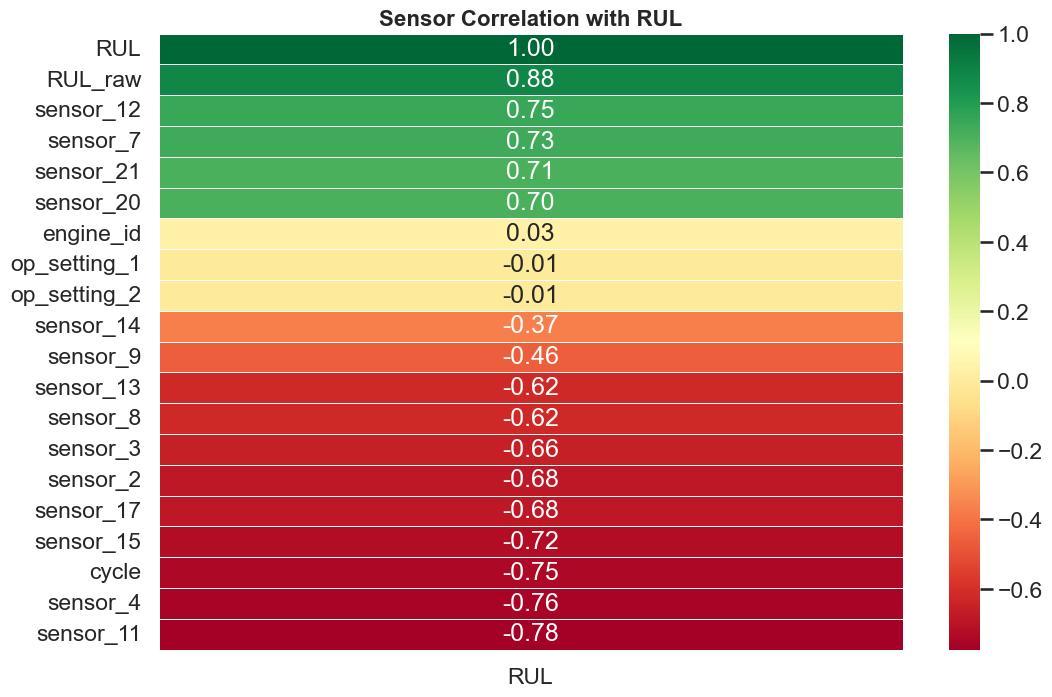

In [121]:
corr_matrix = train_df.corr()
rul_corr = corr_matrix['RUL'].sort_values(ascending=False).to_frame()

plt.figure(figsize=(12, 8))
sns.heatmap(rul_corr, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=0.5)
plt.title('Sensor Correlation with RUL', fontsize=16, fontweight='bold')
plt.show()

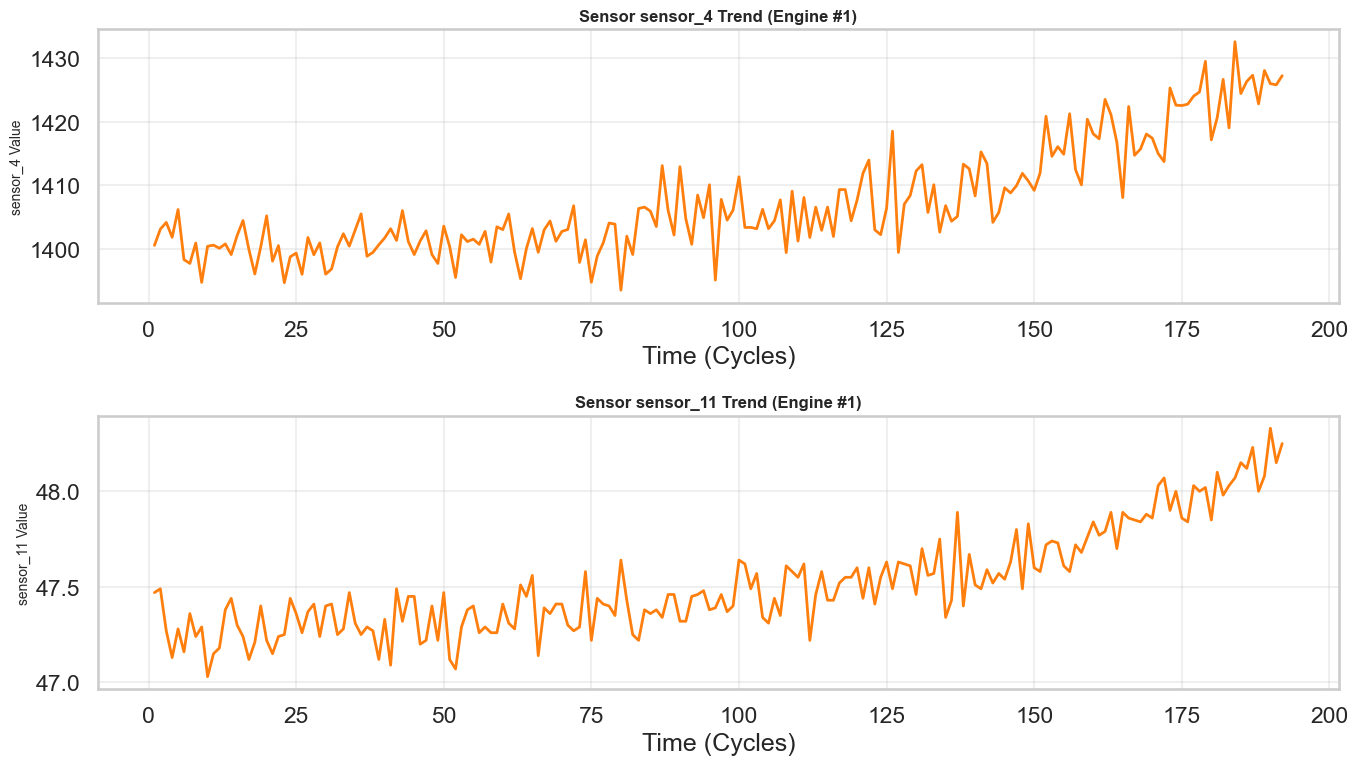

In [112]:
top_sensors = ['sensor_4', 'sensor_11']
sample_unit = 1

fig, ax = plt.subplots(len(top_sensors), 1, figsize=(14, 8))

for i, sensor in enumerate(top_sensors):
    unit_data = train_df[train_df['engine_id'] == sample_unit]
    ax[i].plot(unit_data['cycle'], unit_data[sensor], color='#ff7f0e', linewidth=2)
    ax[i].set_title(f'Sensor {sensor} Trend (Engine #{sample_unit})', fontsize=12, fontweight='bold')
    ax[i].set_ylabel(f'{sensor} Value', fontsize=10)
    ax[i].set_xlabel('Time (Cycles)')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [113]:
def plot_engine_evolution(df, sensor_name, rolling_window=15):
    # Safety check
    if sensor_name not in df.columns:
        print(f"{sensor_name} not found in dataframe.")
        return

    plt.figure(figsize=(13, 7))

    # Plot every 10th engine to avoid clutter
    units_to_plot = sorted(df['engine_id'].unique())[::10]

    for unit in units_to_plot:
        unit_data = df[df['engine_id'] == unit].sort_values("RUL")

        # Smooth the sensor signal
        smoothed_signal = (
            unit_data[sensor_name]
            .rolling(window=rolling_window, center=True)
            .mean()
        )

        plt.plot(
            unit_data['RUL'],
            smoothed_signal,
            linewidth=2,
            alpha=0.6
        )

    # Reverse X-axis: High RUL → Failure
    plt.xlim(df['RUL'].max(), 0)

    # Critical zone
    plt.axvspan(
        30, 0,
        color='red',
        alpha=0.1,
        label='Critical Zone (<30 cycles)'
    )

    plt.title(
        f"Sensor Degradation Pattern: {sensor_name}",
        fontsize=16,
        fontweight='bold'
    )
    plt.xlabel("Remaining Useful Life (RUL)")
    plt.ylabel(f"{sensor_name} (Smoothed)")

    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


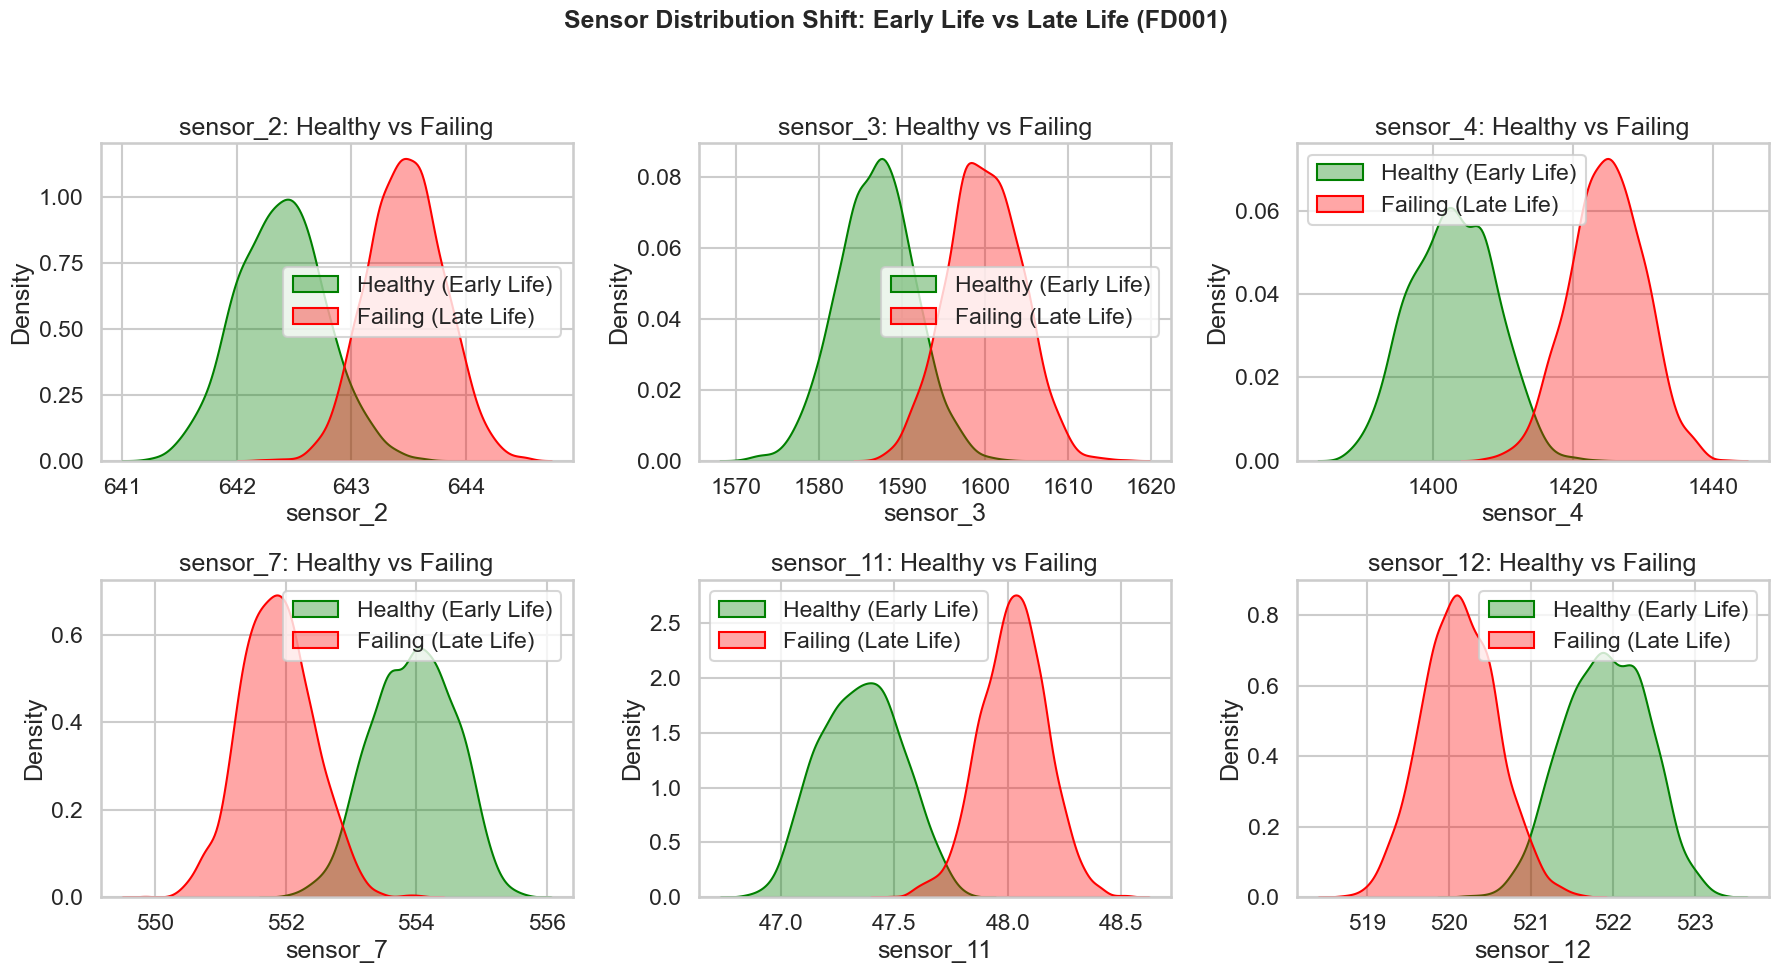

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

early_life = train_df[train_df["cycle"] <= 20]
late_life = train_df[train_df["RUL"] <= 20]

sensors_to_compare = [
    "sensor_2",
    "sensor_3",
    "sensor_4",
    "sensor_7",
    "sensor_11",
    "sensor_12"
]

available_sensors = [s for s in sensors_to_compare if s in train_df.columns]

sns.set(style="whitegrid", context="talk")

if available_sensors:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, sensor in enumerate(available_sensors):
        sns.kdeplot(
            early_life[sensor],
            fill=True,
            color="green",
            alpha=0.35,
            label="Healthy (Early Life)",
            ax=axes[i]
        )
        sns.kdeplot(
            late_life[sensor],
            fill=True,
            color="red",
            alpha=0.35,
            label="Failing (Late Life)",
            ax=axes[i]
        )
        axes[i].set_title(f"{sensor}: Healthy vs Failing")
        axes[i].legend()

    plt.suptitle(
        "Sensor Distribution Shift: Early Life vs Late Life (FD001)",
        fontsize=18,
        fontweight="bold"
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("No valid sensors found in dataset.")


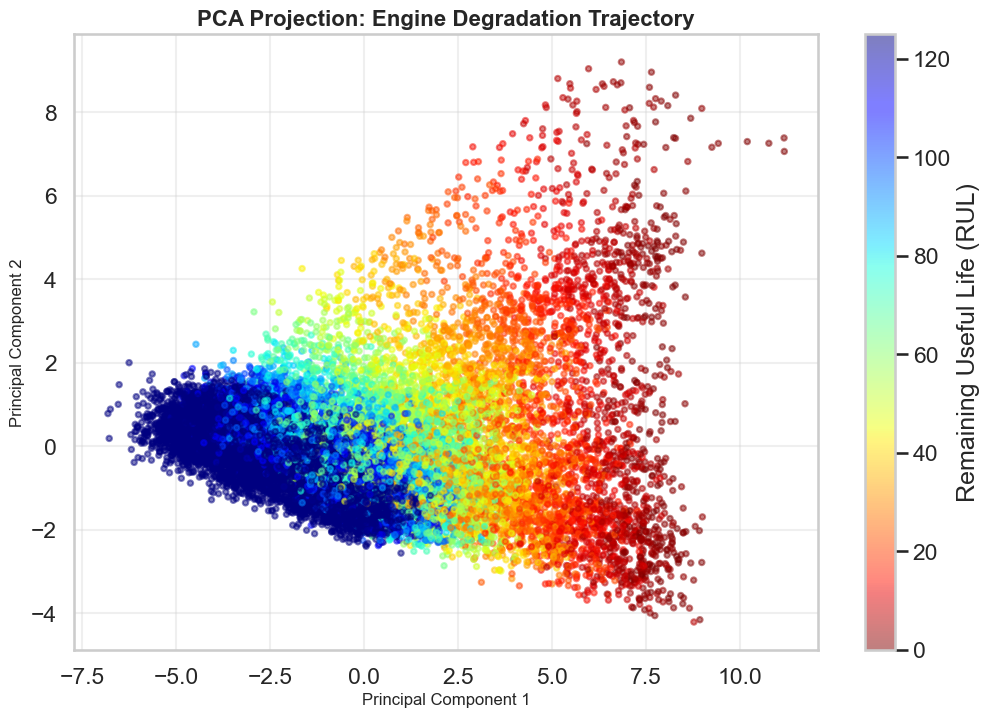

Explained Variance Ratio: 65.19%
Meaning: These 2 components hold 65% of the sensors' information.


In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

features_for_pca = [
    col for col in train_df.columns
    if col not in ["engine_id", "cycle", "RUL"]
]

x_pca = StandardScaler().fit_transform(train_df[features_for_pca])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_pca)

pca_df = pd.DataFrame(
    data=principal_components,
    columns=["PC1", "PC2"]
)

pca_df["RUL"] = train_df["RUL"]

plt.figure(figsize=(12, 8))
sc = plt.scatter(
    pca_df["PC1"],
    pca_df["PC2"],
    c=pca_df["RUL"],
    cmap="jet_r",
    alpha=0.5,
    s=15
)

plt.colorbar(sc, label="Remaining Useful Life (RUL)")
plt.title("PCA Projection: Engine Degradation Trajectory", fontsize=16, fontweight="bold")
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_.sum():.2%}")
print(
    "Meaning: These 2 components hold {:.0f}% of the sensors' information."
    .format(pca.explained_variance_ratio_.sum() * 100)
)



# MODEL LSTM

In [155]:
DEGRADING_DOWN = [
    'sensor_2','sensor_3','sensor_4',
    'sensor_7','sensor_11','sensor_15','sensor_17'
]

DEGRADING_UP = [
    'sensor_12','sensor_20','sensor_21'
]

CORE_SENSORS = DEGRADING_DOWN + DEGRADING_UP


In [156]:
BASELINE_CYCLES = 20

baseline_df = (
    train_df[train_df['cycle'] <= BASELINE_CYCLES]
    .groupby('engine_id')[CORE_SENSORS]
    .mean()
)


In [164]:
def add_engineered_features(df, baseline_df):
    df = df.copy()

    for s in DEGRADING_DOWN:
        df[f"{s}_dev"] = baseline_df.loc[df.engine_id, s].values - df[s]

    for s in DEGRADING_UP:
        df[f"{s}_dev"] = df[s] - baseline_df.loc[df.engine_id, s].values

    TREND_WIN = 5
    for s in CORE_SENSORS:
        df[f"{s}_trend"] = (
            df.groupby("engine_id")[s]
            .rolling(TREND_WIN)
            .mean()
            .reset_index(level=0, drop=True)
        )

    return df


In [165]:
train_df = add_engineered_features(train_df, baseline_df)
test_df  = add_engineered_features(test_df, baseline_df)


In [166]:
for s in DEGRADING_DOWN:
    train_df[f"{s}_dev"] = train_df[s].map(
        baseline_df[s]
    ) - train_df[s]

    test_df[f"{s}_dev"] = test_df[s].map(
        baseline_df[s]
    ) - test_df[s]

for s in DEGRADING_UP:
    train_df[f"{s}_dev"] = train_df[s] - train_df[s].map(
        baseline_df[s]
    )

    test_df[f"{s}_dev"] = test_df[s] - test_df[s].map(
        baseline_df[s]
    )


In [167]:
TREND_WIN = 5

for s in CORE_SENSORS:
    train_df[f"{s}_trend"] = (
        train_df
        .groupby("engine_id")[s]
        .rolling(TREND_WIN, min_periods=1)  # ← important
        .mean()
        .reset_index(level=0, drop=True)
    )

    test_df[f"{s}_trend"] = (
        test_df
        .groupby("engine_id")[s]
        .rolling(TREND_WIN, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )


In [169]:
feature_cols = []

# Raw normalized sensors
feature_cols += CORE_SENSORS

# Deviation-from-healthy
feature_cols += [f'{s}_dev' for s in CORE_SENSORS]

# Short-term trends
feature_cols += [f'{s}_trend' for s in CORE_SENSORS]


In [170]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

MAX_RUL = 125
SEQ_LEN = 50

# Use only healthy region for fitting scaler
healthy_df = train_df[train_df["RUL"] > 0.8 * MAX_RUL]

scaler = MinMaxScaler()
scaler.fit(healthy_df[feature_cols])

train_df[feature_cols] = scaler.transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])


C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\_array_api.py:686: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\_array_api.py:706: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [171]:


SEQ_LEN = 50

def create_sequences(df, feature_cols, seq_len):
    X, y = [], []

    for engine_id in df["engine_id"].unique():
        engine_data = df[df["engine_id"] == engine_id]

        features = engine_data[feature_cols].values
        rul = engine_data["RUL"].values

        for i in range(len(engine_data) - seq_len):
            X.append(features[i:i + seq_len])
            y.append(rul[i + seq_len - 1])  

    return np.array(X), np.array(y)


In [146]:
X_train, y_train = create_sequences(train_df, feature_cols, SEQ_LEN)


In [147]:
def create_test_sequences(df, feature_cols, seq_len):
    X = []

    for engine_id in df["engine_id"].unique():
        engine_data = df[df["engine_id"] == engine_id]
        features = engine_data[feature_cols].values

        if len(features) >= seq_len:
            X.append(features[-seq_len:])
        else:
            pad = np.zeros((seq_len - len(features), features.shape[1]))
            X.append(np.vstack((pad, features)))

    return np.array(X)


In [172]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)


X_train: (15631, 50, 16)
y_train: (15631,)
X_test: (100, 30, 16)


In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, LayerNormalization

model = Sequential()

model.add(
    Masking(
        mask_value=0.0,
        input_shape=(X_train.shape[1], X_train.shape[2])
    )
)

model.add(LSTM(128, return_sequences=True))
model.add(LayerNormalization())

model.add(LSTM(64, return_sequences=True))
model.add(LayerNormalization())

model.add(LSTM(32, return_sequences=False))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(1))


C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import tensorflow as tf

MAX_RUL = 125
DELTA = 15.0

def late_life_weighted_huber(y_true, y_pred):
    error = y_true - y_pred
    abs_error = tf.abs(error)

    huber = tf.where(
        abs_error <= DELTA,
        0.5 * tf.square(error),
        DELTA * (abs_error - 0.5 * DELTA)
    )

    
    weight = 1.0 + tf.square((MAX_RUL - y_true) / MAX_RUL)

    return tf.reduce_mean(weight * huber)


In [175]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=late_life_weighted_huber
)


In [176]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 128)        │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 50, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,625 (541.50 KB)

 Trainable params: 138,625 (541.50 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

lr_decay = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=4,
    min_lr=1e-5,
    verbose=1
)

model.compile(
    optimizer=Adam(
        learning_rate=1e-3,
        clipnorm=1.0
    ),
    loss=late_life_weighted_huber
)

history = model.fit(
    X_train,
    y_train,
    epochs=120,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, lr_decay],
    verbose=1
)


Epoch 1/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 837.2749 - val_loss: 642.7977 - learning_rate: 0.0010
Epoch 2/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 545.0386 - val_loss: 331.8187 - learning_rate: 0.0010
Epoch 3/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 168.1400 - val_loss: 144.9144 - learning_rate: 0.0010
Epoch 4/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 140.0148 - val_loss: 153.9606 - learning_rate: 0.0010
Epoch 5/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 134.4030 - val_loss: 102.7524 - learning_rate: 0.0010
Epoch 6/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 129.1460 - val_loss: 127.1738 - learning_rate: 0.0010
Epoch 7/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 126.3120 - val_loss: 139.4124 - learning_rate: 0.0010
Epoch 8/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 124.5387 - val_loss: 97.9103 - learning_rate: 0.0010
Epoch 9/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 12

In [178]:

y_pred = model.predict(X_test, verbose=0).flatten()


In [181]:
y_true = np.loadtxt("D:\Predict\data\RUL_FD001.txt")


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\KIIT\AppData\Local\Temp\ipykernel_3768\2659218419.py:1: SyntaxWarning: invalid escape sequence '\P'
  y_true = np.loadtxt("D:\Predict\data\RUL_FD001.txt")


In [182]:
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
print("FD001 RMSE:", rmse)


FD001 RMSE: 41.60236535456004


In [183]:
print("Pred range:", y_pred.min(), y_pred.max())
print("True range:", y_true.min(), y_true.max())


Pred range: 73.5484 73.5484
True range: 7.0 145.0


In [136]:
health_percent = (y_pred / MAX_RUL) * 100

def health_zone(h):
    if h > 70:
        return "Healthy"
    elif h > 30:
        return "Warning"
    else:
        return "Critical"


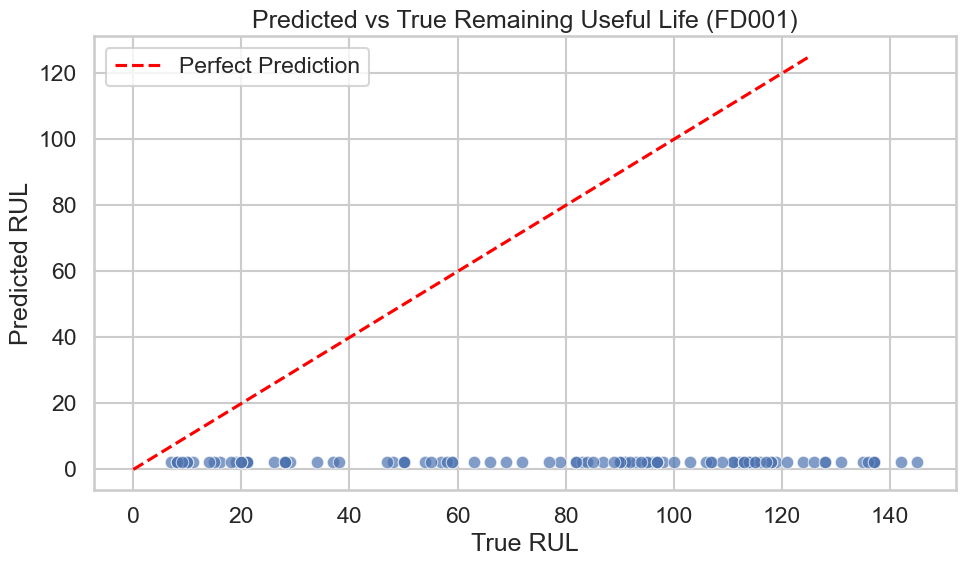

In [137]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=rul_df["RUL"],
    y=y_pred,
    alpha=0.7
)

plt.plot(
    [0, MAX_RUL],
    [0, MAX_RUL],
    color="red",
    linestyle="--",
    label="Perfect Prediction"
)

plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs True Remaining Useful Life (FD001)")
plt.legend()
plt.tight_layout()
plt.show()


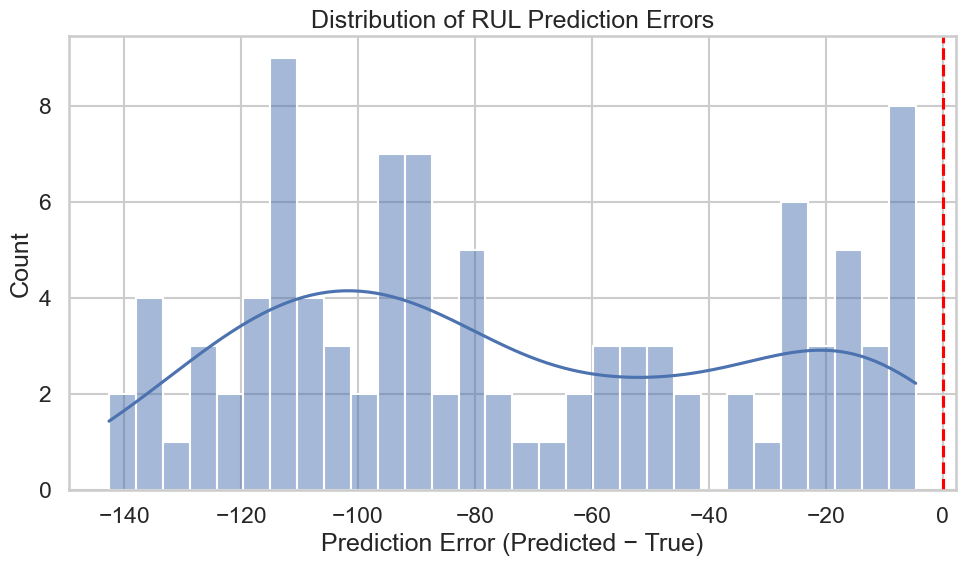

In [138]:
errors = y_pred - rul_df["RUL"]

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)

plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Prediction Error (Predicted − True)")
plt.title("Distribution of RUL Prediction Errors")
plt.tight_layout()
plt.show()


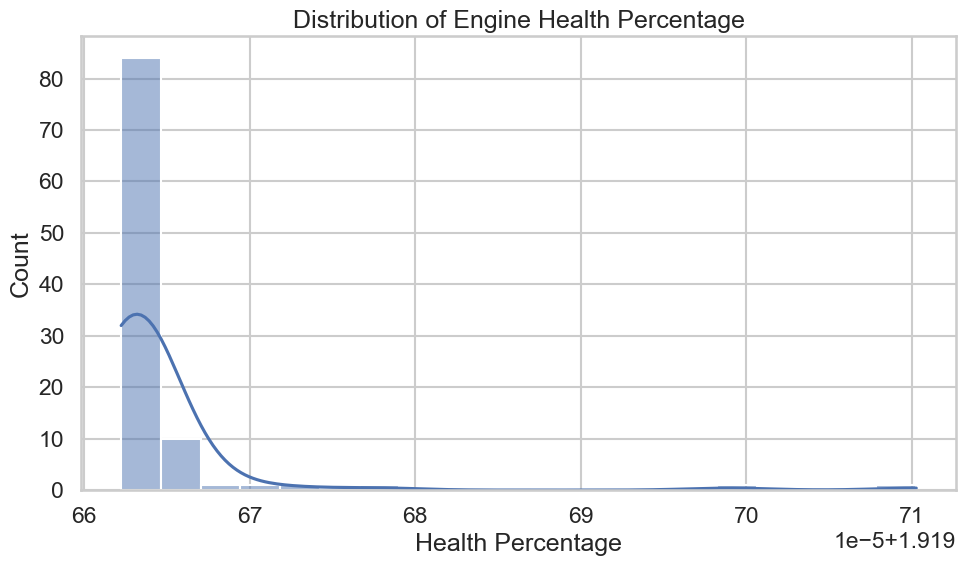

In [139]:
plt.figure(figsize=(10, 6))
sns.histplot(health_percent, bins=20, kde=True)

plt.xlabel("Health Percentage")
plt.ylabel("Count")
plt.title("Distribution of Engine Health Percentage")
plt.tight_layout()
plt.show()


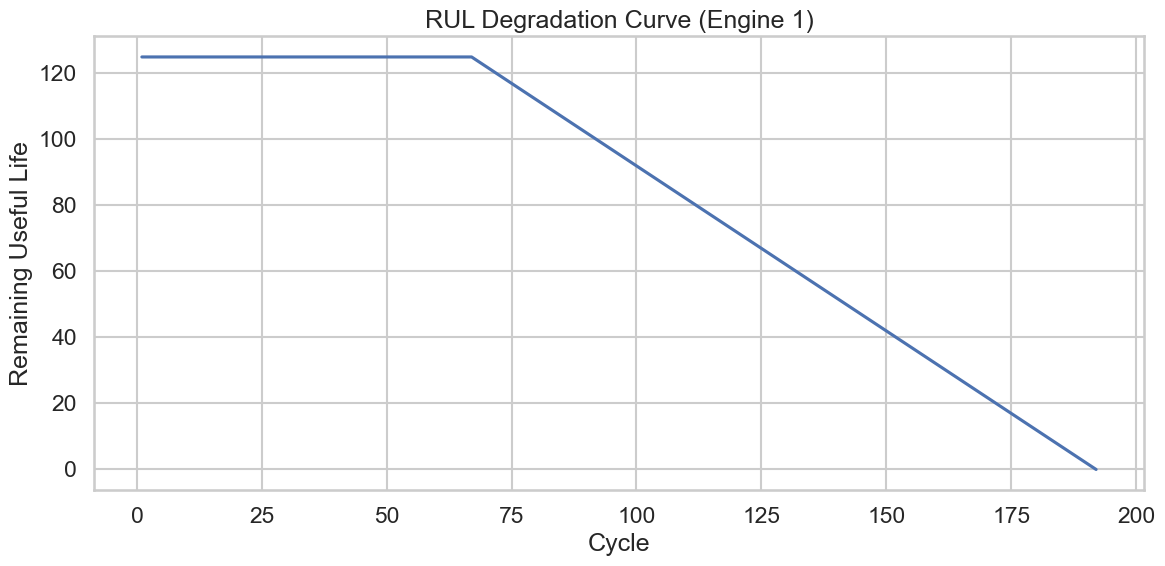

In [140]:
engine_id = 1  # change to any engine ID

engine_data = train_df[train_df["engine_id"] == engine_id]

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data["RUL"]
)

plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life")
plt.title(f"RUL Degradation Curve (Engine {engine_id})")
plt.tight_layout()
plt.show()



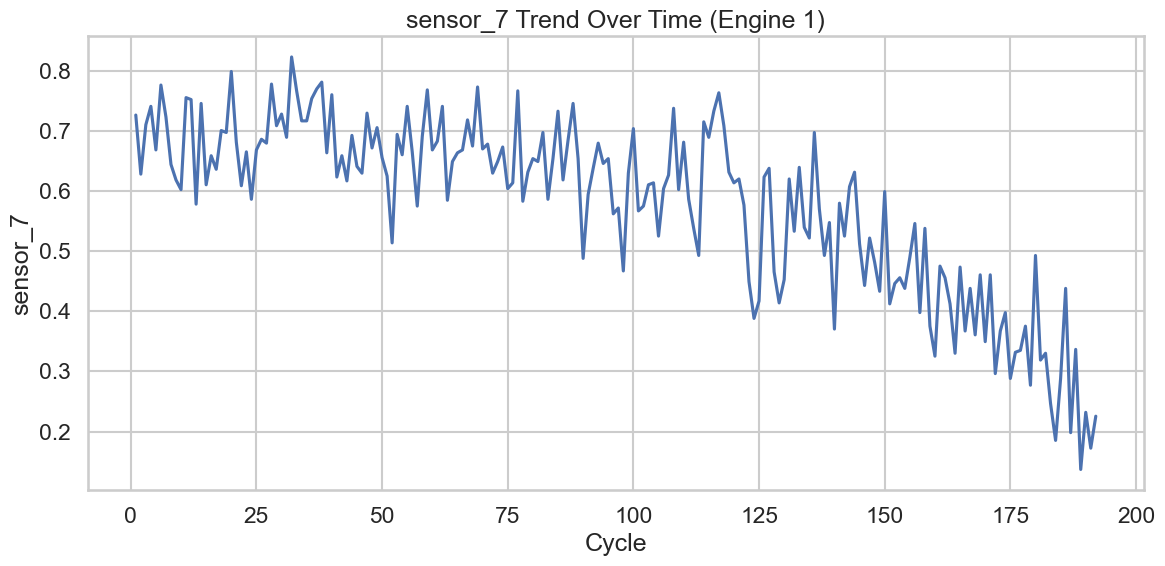

In [141]:
sensor_name = "sensor_7"  # choose any kept sensor

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data[sensor_name]
)

plt.xlabel("Cycle")
plt.ylabel(sensor_name)
plt.title(f"{sensor_name} Trend Over Time (Engine {engine_id})")
plt.tight_layout()
plt.show()
